<a href="https://colab.research.google.com/github/pinkesh-ai/DL201/blob/main/PinAI21_06_multicat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 38.2MB/s 
     |████████████████████████████████| 1.2MB 48.5MB/s 
     |████████████████████████████████| 204kB 54.2MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *

PASCAL dataset

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test.json')]

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


As you can see, the list of categories in each image is shown as a space-delimited string.

### Sidebar: Pandas and DataFrames

No, it’s not actually a panda! *Pandas* is a Python library that is used to manipulate and analyze tabular and time series data. The main class is `DataFrame`, which represents a table of rows and columns. You can get a DataFrame from a CSV file, a database table, Python dictionaries, and many other sources. In Jupyter, a DataFrame is output as a formatted table, as shown here.

You can access rows and columns of a DataFrame with the `iloc` property, as if it were a matrix:

In [ ]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [ ]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

You can also grab a column by name by indexing into a DataFrame directly:

In [ ]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

You can create new columns and do calculations using columns:

In [ ]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [ ]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


Now that we have seen what the data looks like, let's make it ready for model training.

In [ ]:
dblock = DataBlock()

We can create a `Datasets` object from this. The only thing needed is a source—in this case, our DataFrame:

In [ ]:
dsets = dblock.datasets(df)

This contains a `train` and a `valid` dataset, which we can index into:

In [ ]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [ ]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [ ]:
x['fname']

'008663.jpg'

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [ ]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

 **one-hot encoding**. 

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

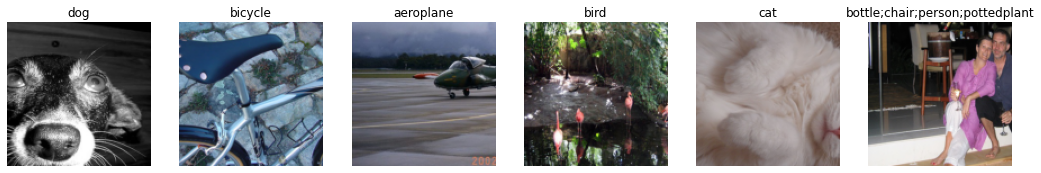

In [ ]:
dls.show_batch(nrows=1, ncols=6)

### Binary Cross-Entropy

**Learner**

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [ ]:
activs[0]

tensor([-0.3331,  6.4825, -0.8776,  3.3945,  1.2616, -0.6367, -2.1945,  4.4255,  0.3934, -1.1779,  0.7778,  1.5323,  4.4392, -0.6144, -1.3245, -2.5475,  2.8060, -5.6149, -2.2486, -3.4112],
       grad_fn=<SelectBackward>)

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0790, grad_fn=<AliasBackward>)

In [ ]:
def say_hello(name, say_what="Hello"): 
    return f"{say_what} {name}."

say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.946299,0.705000,0.238825,00:27
1,0.822499,0.553525,0.292749,00:27
2,0.603312,0.207376,0.802908,00:27
3,0.359258,0.125708,0.938426,00:27


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135184,0.112649,0.944741,00:28
1,0.116434,0.105182,0.951972,00:29
2,0.098015,0.101751,0.951175,00:28


Picking a threshold is important. **If you pick a threshold that's too low, you'll often be failing to select correctly labeled objects.** We can see this by changing our metric, and then calling `validate`, which returns the validation loss and metrics:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10175123810768127,0.9278087019920349]

**If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident**:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10175123810768127,0.9441235065460205]

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [ ]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9571)

We can now use this approach to find the best threshold level:

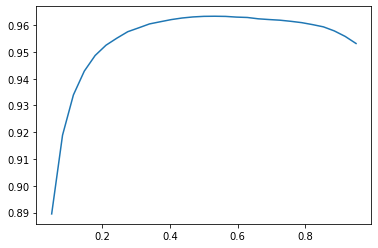

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Regression

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
Path.BASE_PATH = path

Let's see what we've got!

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here). Let's take a look inside one of these directories:

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside the subdirectories, we have different frames, each of them come with an image (*\_rgb.jpg*) and a pose file (*\_pose.txt*). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file:

In [ ]:
img_files = get_image_files(path)

def img2pose(x): 
    return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('03/frame_00728_pose.txt')

Let's take a look at our first image:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

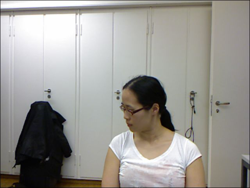

In [ ]:
im.to_thumb(250)

In [ ]:
# Show the content of one pose text file
with open(img2pose(img_files[0]), 'r') as f:
    txt = f.read()
    print(f"Content of {img2pose(img_files[0]).name}\n{'-'*30}")
    print(txt)

Content of frame_00728_pose.txt
------------------------------
0.48795 0.176642 0.854811 
0.182586 0.936989 -0.297849 
-0.853561 0.301413 0.424951 

48.1 67.87 902.399 




In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

# see documentation fpr genfromtxt here: https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html

def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

tensor([347.5935, 279.4350])

In [ ]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)), 
                 Normalize.from_stats(*imagenet_stats)]
                 )

Before doing any modeling, we should look at our data to confirm it seems okay:

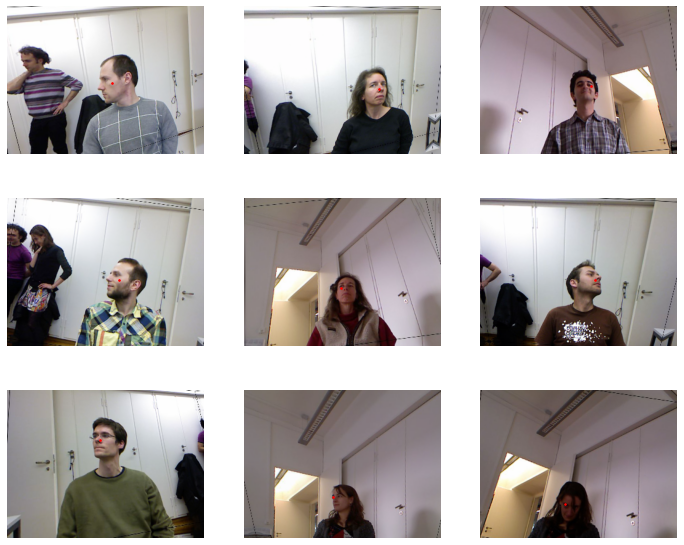

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(12,10))

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Make sure that you understand *why* these are the shapes for our mini-batches.

Here's an example of one row from the dependent variable:

In [ ]:
yb[0]

TensorPoint([[-0.1869,  0.0392]], device='cuda:0')

### Training a Model

In [ ]:
def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi-lo) + lo

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


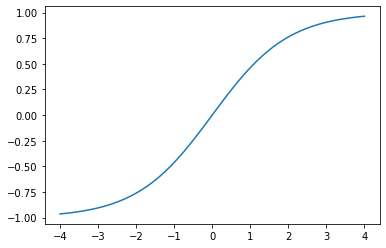

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4);

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.03981071710586548)

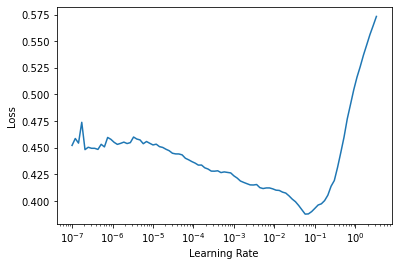

In [ ]:
learn.lr_find()

We'll try an LR of 1e-2:

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.045950,0.003060,01:59


epoch,train_loss,valid_loss,time
0,0.008030,0.003300,02:09
1,0.002984,0.000615,02:08
2,0.001475,0.000081,02:09


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [ ]:
math.sqrt(0.0001)

0.01

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

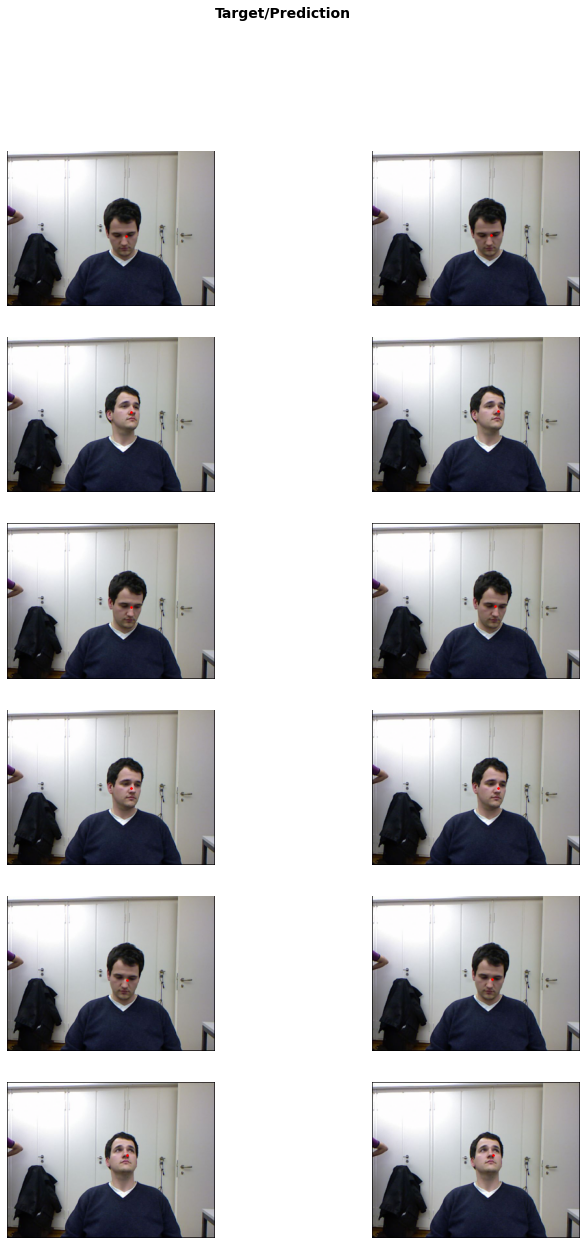

In [ ]:
learn.show_results(ds_idx=1, nrows=6, figsize=(12,20))

## Conclusion

## Assignment 1: DataLoaders and DataBlocks

There are several ways to create a DataLoaders and DataBlocks. We already had seen two before this chapter:

- Factory function building the DataLoaders directly
``` 
dls = ImageDataLoaders.from_name_func(path, get_image_files(path), 
                                        valid_pct=0.2, seed=42,
	                                    label_func=is_cat, item_tfms=Resize(224))
```
- Building a DataBlock then the DataLoaders
```
bears = DataBlock(blocks=(ImageBlock, CategoryBlock), 
		                    get_items=get_image_files, 
		                    splitter=RandomSplitter(valid_pct=0.2, seed=42),
                            get_y=parent_label,
                            item_tfms=Resize(128))
dls = bears.dataloaders(path)
```

In this notebook we see how the DataBlock can be built step by step and how the functions for `get_items`, `get_y`, `splitter`, can be customized for our own application.

This is a good approach for when we are building a model and we are experimenting. After that it will be a good practice to refactor the code and make it more structured so that it is easier to understand when you go back to the code weeks later.

**Assignment**: 
Refactor the code used in the multi label classification problem so that it holds in a few cells and reads logically. Comment where you need. Then run `.summary` to confirm all is running well and then create a dls and a model to run a few epochs of training.

In [ ]:
# 1.Enter your code for the DataBlock and related custom functions. You can use several cells if more convenient

In [ ]:
dblock = DataBlock()

In [ ]:
dsets = dblock.datasets(df)

In [ ]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [ ]:
# 2.Enter the code to test you DabaBlock with summary

In [ ]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('002142.jpg', 'person')

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

In [ ]:
# 3.Enter you code to create the dls, create the model and run a few epochs

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.918488,0.264800,1.000000,04:01
1,0.248967,0.008275,1.000000,04:00
2,0.026514,0.006886,1.000000,04:00
3,0.025435,0.007643,1.000000,04:00


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.007091,0.001557,1.000000,05:19
1,0.003405,0.001166,1.000000,05:19
2,0.001788,0.000184,1.000000,05:19


In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

In [1]:
#Thanks

#### Conclusions and Reflections:
- Refactoring- I beleive that innovating or adding new steps in the basic model can obtain a more effective result.

## Assignment 2: Discover a new dataset

Image datasets come in many forms, and this is why fastai has so many different ways to create DataBlocks. In this notebook we are exposed to a new dataset (Biwi Kinect) and we are told that the label information is in the csv file. How do we do this ourselves? Where did we find additonal information?

The first assignement is to figure out how to import information from a new dataset. The steps:
1. Explore the files to identify what information can be gathered (README file, meta data, ...?)
2. Decide what the right approach is for the dataset
3. Create the DataLoaders and test it.

We will do that the for *Biwi Kinect Head Pose Database* dataset we used above. It will show you where some of the information used comes from.

In [ ]:
# Load the dataset
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

### 1. Explore the files and folders in the dataset

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

Lots of stuff. Let's make a list of list of files, list of text files, list of folders, ... (this uses the parameters and methods of `pathlib.Path` ([doc](https://docs.python.org/3/library/pathlib.html#concrete-paths)). `pathlib.Path` is imported as part of `fastai`:

In [ ]:
print('Files:')
print(' ', [p.name for p in path.ls().sorted() if p.is_file()])
print('Text Files:')
print(' ', [p.name for p in path.ls() if p.suffix == '.txt'])
print('Obj Files')
print(' ', [p.name for p in path.ls() if p.suffix == '.obj'])
print('Folders')
print(' ', [p.name for p in path.ls().sorted() if p.is_dir()])

Files:
  ['01.obj', '02.obj', '03.obj', '04.obj', '05.obj', '06.obj', '07.obj', '08.obj', '09.obj', '10.obj', '11.obj', '12.obj', '13.obj', '14.obj', '15.obj', '16.obj', '17.obj', '18.obj', '19.obj', '20.obj', '21.obj', '22.obj', '23.obj', '24.obj', 'io_sample.cpp', 'readme.txt']
Text Files:
  ['readme.txt']
Obj Files
  ['12.obj', '11.obj', '16.obj', '06.obj', '04.obj', '14.obj', '10.obj', '22.obj', '24.obj', '03.obj', '23.obj', '07.obj', '20.obj', '15.obj', '05.obj', '17.obj', '21.obj', '19.obj', '01.obj', '08.obj', '13.obj', '18.obj', '09.obj', '02.obj']
Folders
  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


We see there is a **readme file**. Let's read it !

In [ ]:
with open(path/'readme.txt', 'r') as f:
    txt = f.read()

print(txt)

Biwi Kinect Head Pose Database

This database is made available for non-commercial use such as university research and education.

We kindly ask you to cite the following reference in your publications related to this work:

@article{fanelli_IJCV,
  author = {Fanelli, Gabriele and Dantone, Matthias and Gall, Juergen and Fossati, Andrea and Van Gool, Luc},
  title = {Random Forests for Real Time 3D Face Analysis},
  journal = {Int. J. Comput. Vision},
  year = {2013},
  month = {February},
  volume = {101},
  number = {3},
  pages = {437--458}
}

The database contains 24 sequences acquired with a Kinect sensor. 20 people (some were recorded twice - 6 women and 14 men) were recorded while turning their heads, sitting in front of the sensor, at roughly one meter of distance.

For each sequence, the corresponding .obj file represents a head template deformed to match the neutral face of that specific person.
In each folder, two .cal files contain calibration information for the depth and t

We also can review the content of one of the folders:

In [ ]:
folder = path / '01'
list_of_paths = folder.ls().sorted()

print('Files:')
print(' ', [p.name for p in list_of_paths if p.is_file()])
print('Text Files:')
print(' ', [p.name for p in list_of_paths if p.suffix == '.txt'])
print('image files')
print(' ', [p.name for p in list_of_paths if p.suffix == '.jpg'])
print('Calibration Files')
print(' ', [p.name for p in list_of_paths if p.suffix == '.cal'])
print('Other files')
print(' ', [p.name for p in list_of_paths if p.is_file() and p.suffix not in ['.txt', '.cal', '.jpg']])
print('Set of file for one frame')
print(' ', [p.name for p in list_of_paths if p.is_file() and '_00003_' in p.name])

Files:
  ['depth.cal', 'frame_00003_pose.txt', 'frame_00003_rgb.jpg', 'frame_00004_pose.txt', 'frame_00004_rgb.jpg', 'frame_00005_pose.txt', 'frame_00005_rgb.jpg', 'frame_00006_pose.txt', 'frame_00006_rgb.jpg', 'frame_00007_pose.txt', 'frame_00007_rgb.jpg', 'frame_00008_pose.txt', 'frame_00008_rgb.jpg', 'frame_00009_pose.txt', 'frame_00009_rgb.jpg', 'frame_00010_pose.txt', 'frame_00010_rgb.jpg', 'frame_00011_pose.txt', 'frame_00011_rgb.jpg', 'frame_00012_pose.txt', 'frame_00012_rgb.jpg', 'frame_00013_pose.txt', 'frame_00013_rgb.jpg', 'frame_00014_pose.txt', 'frame_00014_rgb.jpg', 'frame_00015_pose.txt', 'frame_00015_rgb.jpg', 'frame_00016_pose.txt', 'frame_00016_rgb.jpg', 'frame_00017_pose.txt', 'frame_00017_rgb.jpg', 'frame_00018_pose.txt', 'frame_00018_rgb.jpg', 'frame_00019_pose.txt', 'frame_00019_rgb.jpg', 'frame_00020_pose.txt', 'frame_00020_rgb.jpg', 'frame_00021_pose.txt', 'frame_00021_rgb.jpg', 'frame_00022_pose.txt', 'frame_00022_rgb.jpg', 'frame_00023_pose.txt', 'frame_00023_

In [ ]:
with open(path/'01/rgb.cal', 'r') as f:
    txt = f.read()
print(txt)

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480



In [ ]:
with open(path/'01/frame_00003_pose.txt', 'r') as f:
    txt = f.read()
print(txt)

0.997978 0.0272944 0.0574071 
-0.0346956 0.990621 0.132163 
-0.0532613 -0.133887 0.989564 

51.9358 38.2631 881.756 




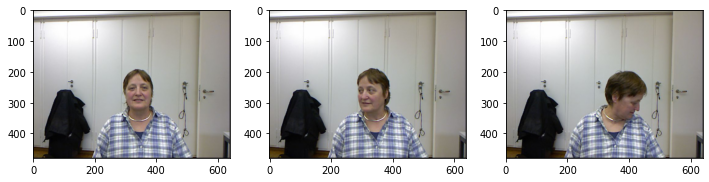

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

img = Image.open(path / '01/frame_00003_rgb.jpg')
axs[0].imshow(img)
img = Image.open(path / '01/frame_00250_rgb.jpg')
axs[1].imshow(img)
img = Image.open(path / '01/frame_00501_rgb.jpg')
axs[2].imshow(img)

plt.show()

## Conclusion and Reflexions
What do you learn in this document, that you can use in order to build a dataset. What information in the readme is not relevant for the problem we want to solve. What in this "inquiry" clarifies some of the operations we have done above in the notebook to frame our regression problem:


- ...
- ...


## Assingment 3: Frame a new regression problem

So far, the instructions on how to build a model were presented step by step to you:
- what we want to do
- how to get the data
- our x and y or independant and dependant variables
- the type of models we need to get.

In this assignment you have a new regression problem to solve, and your mission is to think on the steps you would undertake to resolve it. 

**Regression Problem to solve**:

In the regression above, we take the set of images and the target coordinates of the head center to predict where a head is located. Input (x) are the images and target values to predict are the two coordinates.

But, if you read the ReadMe file well, you will remember that each of the 24 folders consist of a sequence of images of a person turning its head. **Can we predict where the head will be, say, next frames after seeing 5 frames?** 

It is not required to code and build a model. In fact, you may not have learned all the fastai tools required to implement the model. 

Rather, the assignment is to think of how you would go about resolving the problem, in terms of:
- the data you have (which one to you need)
- the predictions you are trying to achieve
- what you would need your model to take in (x) and learn/predict (y) to achieve your objective.
- how would you need to assemble a specific dataset from the data you have already (x and y)
- ...

### Answer:

*write a short list of steps, in the form of instructions to yourself or the person who would code this later on.*

## Questionnaire

1. **How could multi-label classification improve the usability of the bear classifier?**
1. **How do we encode the dependent variable in a multi-label classification problem?**
1. How do you access the rows and columns of a DataFrame as if it was a matrix? (Pandas question)
1. How do you get a column by name from a DataFrame? (Pandas question)
1. **What is the difference between a `Dataset` and `DataLoader`?**
1. **What does a `Datasets` object normally contain?**
1. **What does a `DataLoaders` object normally contain?**
1. What does `lambda` do in Python?
1. **What are the methods to customize how the independent and dependent variables are created with the data block API?**
1. **Why is softmax not an appropriate output activation function when using a one hot encoded target?**
1. **Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?**
1. **What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?**
1. **Why can't we use regular accuracy in a multi-label problem?**
1. **When is it okay to tune a hyperparameter on the validation set?**
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. **What is a regression problem? What loss function should you use for such a problem?**
1. **What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?**

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.